In [9]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
#     pca = PCA(n_components=n_components, random_state=rand_seed)
#     principalComponents = pca.fit_transform(df[cols])
#     principalDf = pd.DataFrame(principalComponents)
#     df.drop(cols, axis=1, inplace=True)
#     principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
#     df = pd.concat([df, principalDf], axis=1)
#     return df

In [10]:
df_train_transaction = pd.read_csv('../input/train_transaction.csv')
# df_test_transaction = pd.read_csv('../input/test_transaction.csv')

df_train_identity = pd.read_csv('../input/train_identity.csv')
# df_test_identity = pd.read_csv('../input/test_identity.csv')

df_train = df_train_transaction.merge(df_train_identity, how='left', on='TransactionID')
# df_test = df_test_transaction.merge(df_test_identity, how='left', on='TransactionID')

print(df_train.shape)

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
# df_test.columns = df_test.columns.str.replace('-', '_')

# y_train = df_train['isFraud'].copy()
del df_train_transaction, df_train_identity

(590540, 434)


In [11]:
for col in df_train.select_dtypes(include='object').columns:
    df_train[col] = df_train[col].fillna('Unknown')
    lbl = LabelEncoder()
    df_train[col] = lbl.fit_transform(df_train[col])  # Apply label encoding

df_train.fillna(-999, inplace=True)

X_train = df_train.drop(columns=['isFraud'])
y_train = df_train['isFraud']



In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=0.95)  # Keep 95% of the variance, or you can use n_components=30 to fix the number of components
X_train_pca = pca.fit_transform(X_scaled)

AUC: 0.6592, Precision: 0.8333, Recall: 0.3207, F1: 0.4631


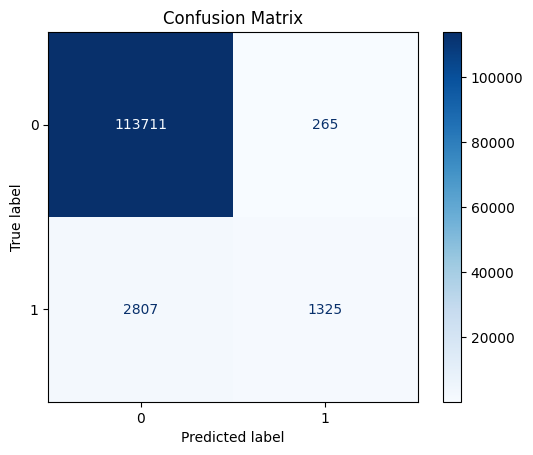

AUC: 0.6572, Precision: 0.8306, Recall: 0.3168, F1: 0.4587


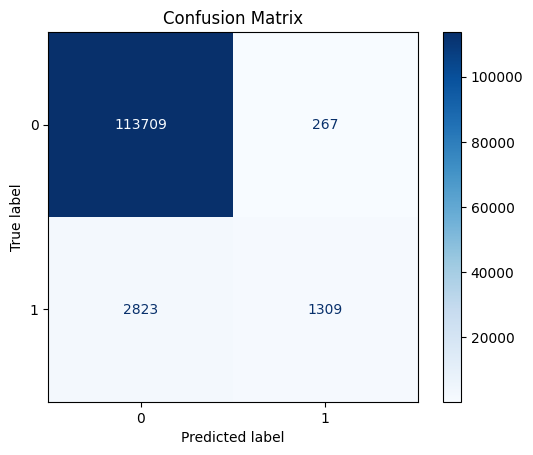

AUC: 0.6615, Precision: 0.8187, Recall: 0.3257, F1: 0.4660


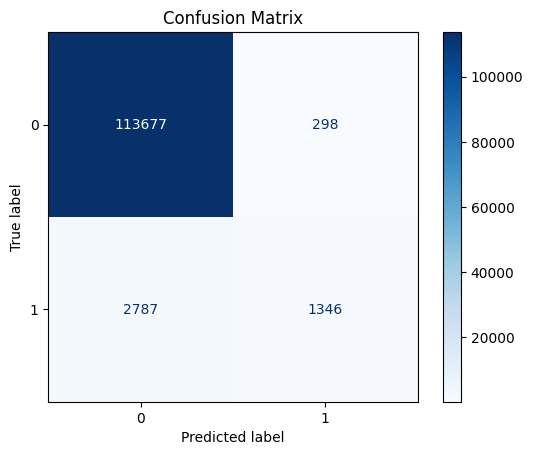

AUC: 0.6586, Precision: 0.8166, Recall: 0.3199, F1: 0.4597


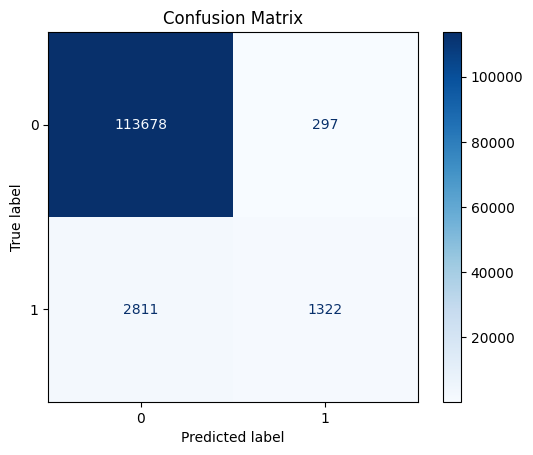

AUC: 0.6559, Precision: 0.8305, Recall: 0.3141, F1: 0.4558


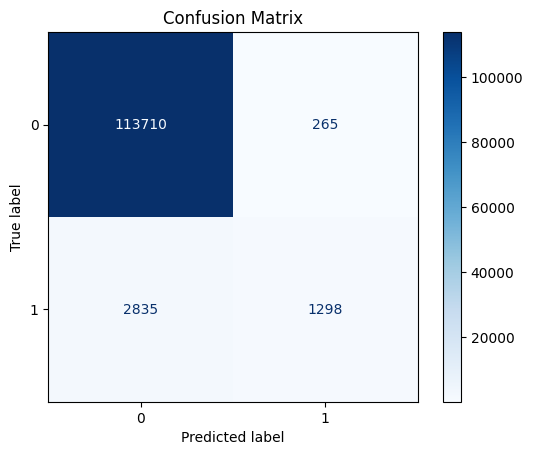


Average Scores Across Folds:
Average AUC: 0.6585
Average Precision: 0.8259
Average Recall: 0.3194
Average F1 Score: 0.4606


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores for each fold
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Cross-validation loop
for train_idx, val_idx in skf.split(X_train_pca, y_train):
    # Split data into train and validation sets
    X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialize the XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=300,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_fold)
    
    # Calculate metrics
    auc = roc_auc_score(y_val_fold, y_val_pred)
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Print performance for each fold
    print(f"AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    # Print confusion matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# After cross-validation, print average scores
print("\nAverage Scores Across Folds:")
print(f"Average AUC: {sum(auc_scores)/len(auc_scores):.4f}")
print(f"Average Precision: {sum(precision_scores)/len(precision_scores):.4f}")
print(f"Average Recall: {sum(recall_scores)/len(recall_scores):.4f}")
print(f"Average F1 Score: {sum(f1_scores)/len(f1_scores):.4f}")